# EPFL Course Recommendation System

# Loading the data

In [1]:
import configparser
import matplotlib.pyplot as plt
import mysql.connector as sql
import numpy as np
import pandas as pd
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

# Read the confidential token.
credentials = configparser.ConfigParser()
credentials.read('../config/credentials.ini')
db_connection = sql.connect(host=credentials.get('mysql', 'url'),
                            database='semester_project_romain',
                            user=credentials.get('mysql', 'username'),
                            password=credentials.get('mysql', 'password'))

In [2]:
# Courses that are either compulsory
# or not useful to recommend
courses_to_remove = [
    "Admission année sup.",
    "Projet de master en systèmes de communication",
    "SHS : Introduction au projet",
    "Cycle master",
    "Projet de Master",
    "Groupe Core courses & options",
    "Bloc Projets et SHS",
    "Groupe 2 : Options",
    "Master SC",
    "Mineur",
    "Groupe 1",
    "Projet en systèmes de communication II",
    "Projet en informatique II",
    "Projet de master en informatique",
    "Cours réservés spécifiquement aux étudiants s'inscrivant pour le mineur Area and Cultural Studies",
    "SHS : Projet",
    "Optional project in communication systems",
    "Optional project in computer science",
    "Mineur : Neurosciences computationnelles",
    "Stage d'ingénieur crédité avec le PDM (master en Systèmes de communication)",
    "Stage d'ingénieur crédité avec le PDM (master en Informatique)",
    "Cours UNIL - Faculté des hautes études commerciales HEC I (printemps)",
    "Chemical engineering of heterogenous reactions",
    "Process development I",
    "Chemical engineering lab & project",
    "Stage d'ingénieur (master en Génie chimique et Biotechnologie)",
    "Projet de master en génie chimique et biotechnologie",
    "Interdisciplinary project",
    "Projet de master en chimie moléculaire et biologique",
    "Project in molecular sciences",
    "Superstudio",
    "Enoncé théorique de master",
    "De la structure à l'ornement",
    "Projet de master en architecture",
    "Pré-étude projet de master",
    "Projet SIE/ENAC",
    "Projet de master en sciences et ingénierie de l'environnement",
    "Stage d'ingénieur crédité avec le PDM (master en Sciences et ingénierie de l'environnement)",
    "Projet de master en génie électrique et électronique",
    "Projet Génie mécanique II",
    "Projet Génie mécanique I",
    "Stage d'ingénieur crédité avec le PDM (master en Génie mécanique)",
    "Projet de master en génie mécanique",
    "Research project in materials I",
    "Projet de master en science et génie des matériaux",
    "Stage d'ingénieur crédité avec le PDM (master en Science et génie des matériaux)",
    "Projet microtechnique I",
    "Projet de master en microtechnique",
    "Stage d'ingénieur crédité avec le PDM (master en Microtechnique)",
    "Projet de master en mathématiques",
    "Projet de Mathématiques (master)",
    "Stage d'ingénieur (master en Ingénierie mathématique)",
    "Projet de master en mathématiques",
    "Projet de Mathématiques (master)",
    "Stage d'ingénieur crédité avec le PDM (master en Ingénierie mathématique)",
    "Stage d'ingénieur (master en Bioingénierie)",
    "Projet de master en bioingénierie et biotechnologie",
    "Stage d'ingénieur (master en Sciences et technologie du vivant)",
    "Projet de master en sciences et technologies du vivant",
    "Stage d'ingénieur (master en Génie nucléaire)",
    "Projet de master en génie nucléaire",
    "Stage d'ingénieur (master en Ingénierie physique)",
    "Projet de master en physique",
    "Stage d'ingénieur (master en Sciences et ingénierie computationnelles)",
    "Projet de master en science et ingénierie computationelles",
    "Projet CSE I",
    "Projet CSE II",
    "Project in energy management and sustainability I",
    "Stage d'ingénieur crédité avec le PDM (master en Gestion de l'énergie et construction durable)",
    "Stage d'ingénieur (master en Génie électrique et électronique)",
]

domains_to_remove = [
    "Humanities and social sciences",
    "Programme Sciences humaines et sociales",
]

In [3]:
units = {
     'Architecture': 'AR',
     'Bioingénierie': 'SV_B',
     'Chimie moléculaire et biologique': 'CGC_CHIM',
     "Gestion de l'énergie et construction durable": 'EME_MES',
     'Génie chimique et biotechnologie': 'CGC_ING',
     'Génie civil': 'GC',
     'Génie mécanique': 'GM',
     'Génie nucléaire': 'PH_NE',
     'Génie électrique et électronique': 'EL',
     'Informatique': 'IN',
     'Ingénierie financière': 'IF',
     'Ingénierie mathématique': 'ING_MATH',
     'Ingénierie physique': 'ING_PHYS',
     'Management, technologie et entrepreneuriat': 'MTEE',
     'Mathématiques - master': 'MATH',
     'Micro and Nanotechnologies for Integrated Systems': 'MNIS',
     'Microtechnique': 'MT',
     'Physique - master': 'PHYS',
     'Science et génie des matériaux': 'MX',
     'Science et ingénierie computationnelles': 'MA_CO',
     "Sciences et ingénierie de l'environnement": 'SIE',
     'Sciences et technologies du vivant - master': 'SV_STV',
     'Systèmes de communication - master': 'SC_EPFL'
}

all_info = """
            select distinct 
                PersonID, 
                PedagogicalCode, 
                StudyDomain, 
                UnitName, 
                UnitID, 
                UnitCode,
                SubjectName, 
                Course_Enrolments.SubjectID,
                SectionName, 
                CourseCode,
                YearName
            from 
                Course_Enrolments
                inner join 
                Course_Codes 
                    on Course_Codes.planid = course_enrolments.planid 
                    and Course_Codes.subjectid = course_enrolments.subjectid
            where 
                {}
                and LevelName = "Master"
            """.format("UnitName = \"{}\"".format(list(units.keys())[9]))

all_df = pd.read_sql(all_info, con=db_connection)
all_df = all_df[~all_df.SubjectName.isin(courses_to_remove)]
all_df = all_df[~(all_df.StudyDomain.isin(domains_to_remove))]
# Mapping of subject ids to subject names
subject_mapping = all_df[['SubjectID', 'SubjectName']].drop_duplicates()
all_df

,PersonID,PedagogicalCode,StudyDomain,UnitName,UnitID,UnitCode,SubjectName,SubjectID,SectionName,CourseCode,YearName
0,29123807,MA1,Architecture,Informatique,249847,IN,Théorie de l'espace,227270058,Architecture,AR-461,2012-2013
1,109679682,MA3,Life sciences,Informatique,249847,IN,Cellular biology and biochemistry for engineers,71603711,Informatique,BIO-105,2008-2009
2,2416702,MA3,Life sciences,Informatique,249847,IN,Cellular biology and biochemistry for engineers,71603711,Informatique,BIO-105,2008-2009
3,40908413,MA3,Life sciences,Informatique,249847,IN,Cellular biology and biochemistry for engineers,71603711,Informatique,BIO-105,2008-2009
4,82030336,MA3,Life sciences,Informatique,249847,IN,Cellular biology and biochemistry for engineers,71603711,Informatique,BIO-105,2008-2009
5,81216365,MA3,Life sciences,Informatique,249847,IN,Cellular biology and biochemistry for engineers,71603711,Informatique,BIO-105,2008-2009
6,4159300,MA3,Life sciences,Informatique,249847,IN,Cellular biology and biochemistry for engineers,71603711,Informatique,BIO-105,2008-2009
7,132597373,MA3,Life sciences,Informatique,249847,IN,Cellular biology and biochemistry for engineers,71603711,Informatique,BIO-105,2008-2009
8,108098778,MA3,Life sciences,Informatique,249847,IN,Cellular biology and biochemistry for engineers,71603711,Informatique,BIO-105,2008-2009
9,127608672,MA1,Life sciences,Informatique,249847,IN,Cellular biology and biochemistry for engineers,71603711,Informatique,BIO-105,2012-2013


## Creating the binary matrix

In [4]:
courses_matrix = all_df[['PersonID', 'SubjectName']]
courses_matrix = courses_matrix.drop_duplicates()
courses_matrix = courses_matrix.set_index(['PersonID', 'SubjectName'])

def series_to_integers(series):
    "Converts a whole series to integers"
    return pd.to_numeric(series, downcast='integer')

# If the course was taken, set it to 1
courses_matrix['joined'] = 1
courses_matrix = courses_matrix.reset_index().pivot(index='PersonID', columns='SubjectName', values='joined')
courses_matrix = courses_matrix.fillna(0)
courses_matrix = courses_matrix.apply(series_to_integers)

# Removing all students that took less than five courses
MIN_COURSES_BY_STUDENT = 10
courses_matrix =courses_matrix[np.sum(courses_matrix == 1, axis=1) > MIN_COURSES_BY_STUDENT]
courses_matrix

SubjectName,Accounting for finance,Advanced algorithms,Advanced analysis I,Advanced analysis II,Advanced compiler construction,Advanced computer architecture,Advanced computer graphics,Advanced computer networks and distributed systems,Advanced cryptography,Advanced databases,...,Topics in theoretical computer science,Traitement automatique de la parole,Traitement quantique de l'information,Traitement quantique de l'information I,Traitement quantique de l'information II,Unsupervised and reinforcement learning in neural networks,VLSI design I,VLSI design I + EDA TP,VLSI design II,Virtual reality
PersonID,,,,,,,,,,,,,,,,,,,,,
2412404,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2414145,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2416702,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2436004,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2480734,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2501514,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2501538,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2505593,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2523797,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Co-enrolment matrix
## Most taken courses
We need to find a way to get a cleaner dataset of courses, a lot of them are not usefull or outdated and should not be recommended.

In [5]:
# Taking a look at the most taken courses
registrations_df = all_df.set_index(['SubjectName', 'YearName'])
registrations_df

PersonID  \
SubjectName                                      YearName                
Théorie de l'espace                              2012-2013    29123807   
Cellular biology and biochemistry for engineers  2008-2009   109679682   
                                                 2008-2009     2416702   
                                                 2008-2009    40908413   
                                                 2008-2009    82030336   
                                                 2008-2009    81216365   
                                                 2008-2009     4159300   
                                                 2008-2009   132597373   
                                                 2008-2009   108098778   
                                                 2012-2013   127608672   
                                                 2012-2013   876419889   
                                                 2012-2013   903788263   
                                                 2012-2013   900069133   
                                                 2012-2013  1151607670   
                                                 2012-2013   910862692   
                                                 2012-2013  1582764441   
                                                 2012-2013   910941871   
                                                 2012-2013   909087663   
                                                 2012-2013   120566031   
                                                 2013-2014  1691292008   
                                                 2013-2014  1685087261   
                                                 2013-2014  1650131965   
                                                 2013-2014   424333800   
                                                 2013-2014  1651854864   
                                                 2013-2014  1650076327   
                                                 2013-2014  1599132940   
                                                 2013-2014   132883209   
                                                 2013-2014  1646914694   
                                                 2013-2014  1646644159   
                                                 2013-2014  1689992936   
...                                                                ...   
Applied machine learning                         2011-2012   918072337   
                                                 2011-2012   351261701   
                                                 2011-2012   903789286   
                                                 2011-2012   351058314   
                                                 2011-2012   384848695   
Biological and artificial intelligent systems    2008-2009   108592781   
                                                 2008-2009   109679682   
                                                 2008-2009   110321679   
                                                 2008-2009   130671211   
Bio-inspired artificial intelligence             2013-2014  1685087261   
                                                 2014-2015  1691577393   
                                                 2009-2010     2545879   
                                                 2010-2011   109717225   
                                                 2010-2011    63605698   
                                                 2011-2012   384848695   
Mobile robots                                    2014-2015  1805406652   
Biomatériaux                                     2011-2012    29123807   
Matériaux biomimétiques                          2011-2012    29123807   
Physique générale II                             2008-2009     2523797   
Astrophysique I : Introduction à l'astrophysique 2013-2014   427510749   
                                                 2013-2014   353950597   
                                                 2014-2015   42751

In [6]:
all_df_registrations = registrations_df.groupby(['SubjectName', 'YearName']).size()

registrations_df['Registration'] = all_df_registrations
registrations_df = registrations_df.reset_index()
# Pick only courses that have a study domain (removes bullshit)
# such as Projects and groups, minors etc
registrations_df = registrations_df[~registrations_df.StudyDomain.isnull()]
# Remove the SHS courses
registrations_df = registrations_df[~(registrations_df.StudyDomain == "Programme Sciences humaines et sociales")]
# Removes non important information
registrations_df = registrations_df.drop([
    'PersonID', "StudyDomain", "SectionName", "PedagogicalCode",
    "CourseCode"], axis=1)
registrations_df = registrations_df.drop_duplicates()
registrations_df = registrations_df.set_index(['SubjectName', 'YearName']).sort_index()
registrations = registrations_df.sort_values(ascending=False, by='Registration')

# Latest data registrations
registrations.xs('2015-2016', level='YearName')

,UnitName,UnitID,UnitCode,SubjectID,Registration
SubjectName,,,,,
Distributed algorithms,Informatique,249847,IN,1773287,128
Pattern classification and machine learning,Informatique,249847,IN,1771468,124
TCP/IP networking,Informatique,249847,IN,1771764,109
Foundations of software,Informatique,249847,IN,71840397,109
Intelligent agents,Informatique,249847,IN,1771183,107
Cryptography and security,Informatique,249847,IN,1770973,101
Concurrent algorithms,Informatique,249847,IN,231901032,90
Unsupervised and reinforcement learning in neural networks,Informatique,249847,IN,1771794,70
Advanced computer graphics,Informatique,249847,IN,1770923,67


## Enrolments

In [7]:
co_enrolments = pd.DataFrame(data=0, columns=courses_matrix.columns, index=courses_matrix.columns)
for row in courses_matrix.iterrows():
    taken_courses = row[1][row[1] == 1].index.tolist()
    for i,course in enumerate(taken_courses):
        co_enrolments.loc[course, taken_courses[i+1:]] += 1
    

# Copy the upper triangle matrix to lower triangle one
co_enrolments = co_enrolments + co_enrolments.T

# Transforming to probabilities and removing the rows summing to nan
co_enrolments = co_enrolments / co_enrolments.sum(axis=0)

def get_coenrolment(course, other_enrolments):
    return co_enrolments.loc[course, other_enrolments].mean()

def training_weight_coenrolments(user_index):
    courses_taken = courses_matrix.iloc[user_index][courses_matrix.iloc[user_index] == 1].index.tolist()
    return [ get_coenrolment(c, courses_taken) for c in courses_matrix.columns.tolist() ]

## Grades correlations inbetween courses

In [8]:
def course_id_mapper(sub_id):
    mapped = subject_mapping[subject_mapping.SubjectID == sub_id].SubjectName
    return mapped.values[0] if not mapped.empty else np.nan

# If one of the correlations is non-existent, return the other
def correlation_series_mean(f_corr, s_corr):
    if f_corr == -5 and s_corr == -5: raise Exception("both correlations non-existent")
    if f_corr == -5 or s_corr == -5: return max(f_corr, s_corr)
    return np.mean([f_corr, s_corr])
    
# Retrieve courses correlations
grade_corr = pd.read_csv('../data/correlation-subject-pair.csv')
grade_corr = grade_corr[['sub1', 'sub2', "cor1", "cor2"]]
grade_corr['cor_mean'] = grade_corr[['cor1', 'cor2']].apply(lambda x: correlation_series_mean(x[0],x[1]), axis=1)
grade_corr = grade_corr[['sub1', 'sub2', 'cor_mean']]

# Use SubjectName instead of SubjectID
grade_corr['sub1_name'] = grade_corr.sub1.map(course_id_mapper)
grade_corr['sub2_name'] = grade_corr.sub2.map(course_id_mapper)
grade_corr = grade_corr.dropna()[['sub1_name', 'sub2_name', 'cor_mean']]

# In case there are no correlations, we set to the mean of all of them
mean_correlations = grade_corr.mean()

# Let's make it a matrix
grade_corr_matrix = grade_corr.set_index(["sub1_name", "sub2_name"]).unstack(level=0).fillna(mean_correlations)
# normalize correlations by adding 1 and dividing by the max
grade_corr_matrix = (grade_corr_matrix + 1)/2

# Set not found courses correlations to the mean of all correlations
no_corr_courses = [ c for c in courses_matrix.columns.tolist() if c not in grade_corr_matrix.index.tolist() ]
missing_correlations = pd.DataFrame(np.full(fill_value=mean_correlations, 
                                            shape=(grade_corr_matrix.shape[0], len(no_corr_courses))), 
                                    columns=no_corr_courses, 
                                    index=grade_corr_matrix.index.tolist())
grade_corr_matrix.columns = grade_corr_matrix.columns.droplevel()
grade_corr_matrix = pd.concat([grade_corr_matrix, missing_correlations], axis=1)

# Let's transform it into probabilistic
grade_corr_matrix = grade_corr_matrix / grade_corr_matrix.sum(axis=0)

def get_grades_corr(course, other_enrolments):
    if course not in grade_corr_matrix.index.tolist():
        return 1/grade_corr_matrix.shape[1]
    return grade_corr_matrix.loc[course, other_enrolments].mean()

def training_weight_grade_corr(user_index):
    courses_taken = courses_matrix.iloc[user_index][courses_matrix.iloc[user_index] == 1].index.tolist()
    return [ get_grades_corr(c, courses_taken) for c in courses_matrix.columns.tolist() ]

# The final dataframe of courses correlations
grade_corr_matrix

,Advanced algorithms,Advanced compiler construction,Advanced computer architecture,Advanced computer graphics,Advanced databases,Algorithms,Algèbre,Analog circuits design I,Analyse I,Analyse II,...,Technology ventures in IC,Test of VLSI systems,Théorie de l'espace,Topics in theoretical computer science,Traitement quantique de l'information,Traitement quantique de l'information I,Traitement quantique de l'information II,VLSI design I,VLSI design I + EDA TP,VLSI design II
sub2_name,,,,,,,,,,,,,,,,,,,,,
Advanced algorithms,0.006325,0.006304,0.006325,0.007003,0.006472,0.006323,0.006361,0.006343,0.006314,0.006316,...,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329
Advanced computer architecture,0.006325,0.006304,0.006325,0.006327,0.006318,0.006323,0.006361,0.006343,0.006314,0.006316,...,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329
Advanced cryptography,0.006325,0.006304,0.006325,0.006327,0.006318,0.006323,0.006361,0.006343,0.006314,0.006316,...,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329
Advanced theoretical computer science,0.006325,0.006304,0.006325,0.006327,0.006318,0.006323,0.006361,0.006343,0.006314,0.006316,...,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329
Algebra,0.006325,0.006304,0.006325,0.006327,0.006318,0.006323,0.006361,0.006343,0.006314,0.006316,...,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329
Algorithms,0.006325,0.006304,0.006325,0.006327,0.006318,0.006323,0.006361,0.006343,0.006314,0.006316,...,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329
Algèbre,0.006325,0.006304,0.006325,0.006327,0.006318,0.006323,0.006361,0.006343,0.006314,0.006316,...,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329
Analyse I,0.006325,0.006304,0.006325,0.006327,0.006318,0.006323,0.006361,0.006343,0.006314,0.006316,...,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329
Analyse II,0.006325,0.006304,0.006325,0.006327,0.006318,0.006323,0.006361,0.006343,0.007482,0.006316,...,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329,0.006329


### Splitting test/train

In [9]:
def split_data(data):
    testing_set = data.applymap(lambda x: 0)

    taken_courses_flat = data.stack().to_frame()
    taken_courses_flat = taken_courses_flat[taken_courses_flat[0] == 1]

    for student in taken_courses_flat.index.get_level_values('PersonID').unique():
        courses = taken_courses_flat.loc[student]
        for course in courses.sample(frac=0.2, replace=False).index:
            testing_set.loc[student, course] = 1
    training_set = data - testing_set

    return training_set, testing_set

training_set, testing_set = split_data(courses_matrix)

# Numpify the data
train_np = training_set.apply(axis=1, func=lambda x: x.astype(int)).as_matrix()
test_np = testing_set.apply(axis=1, func=lambda x: x.astype(int)).as_matrix()

# the indices of each user
users = np.array(np.arange(courses_matrix.shape[0])[np.newaxis].T, dtype=np.int32)

### Metrics

In [10]:
# Precision is the percentage of recommended items that are "good ones"
# Hence, the matched prediction divided by N of Top-N
def precision(y_true, y_pred):
    """
    Takes predictions as an np array of indices,
    true ratings as a numpy array,
    returns precision
    """
    precisions = []
    for i,user in enumerate(y_pred):
        nb_right_pred = sum(y_true[i, user] == 1)
        precisions.append(nb_right_pred / y_pred.shape[1])
    return np.mean(precisions)
    
#Recall is the percentage of good ones that are recommended.
def recall(y_true, y_pred):
    """
    Takes predictions as an np array of indices,
    true ratings as a numpy array,
    returns recall
    """
    recall = []
    for i,user in enumerate(y_pred):
        nb_right_pred = sum(y_true[i, user] == 1)
        recall.append(nb_right_pred / y_true[i].sum())
    return np.mean(recall)
    
def f1_score(y_true, y_pred):
    """
    Takes predictions as an np array of indices,
    true ratings as a numpy array,
    returns f1 score
    """
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    f1 = 2 * (prec * rec) / (prec + rec)
    return f1

def mean_average_precision(y_true, y_pred):
    """
    Takes predictions as an np array of indices,
    true ratings as a numpy array,
    returns the mean average precision
    """
    N = y_pred.shape[1]
    average_prec = []
    for i, user in enumerate(y_pred):
        summed_prec = 0
        for k in np.arange(N):
            prec_k = sum(y_true[i, user] == 1) / N
            rel_k = y_true[i, user[-1]]
            summed_prec += (prec_k * rel_k)
        average_prec.append(summed_prec / min(N, y_true[i].sum()))
    
    return np.mean(average_prec)

#### Collaborative filtering with Collaborative Denoising Auto-Encoders

In [11]:
from keras.layers import Input, Dense, Embedding, Flatten, Dropout, Activation
from keras.layers.merge import Add
from keras.models import Model
from keras.regularizers import l2

def create(I, U, K, hidden_activation, output_activation, q=0.5, l=0.01):
    '''
    create model
    Reference:
      Yao Wu, Christopher DuBois, Alice X. Zheng, Martin Ester.
        Collaborative Denoising Auto-Encoders for Top-N Recommender Systems.
          The 9th ACM International Conference on Web Search and Data Mining (WSDM'16), p153--162, 2016.

    :param I: number of items
    :param U: number of users
    :param K: number of units in hidden layer
    :param hidden_activation: activation function of hidden layer
    :param output_activation: activation function of output layer
    :param q: drop probability
    :param l: regularization parameter of L2 regularization
    :return: CDAE
    :rtype: keras.models.Model
    '''
    x_item = Input((I,), name='x_item')
    h_item = Dropout(q)(x_item)
    h_item = Dense(K, kernel_regularizer=l2(l), bias_regularizer=l2(l))(h_item)

    # dtype should be int to connect to Embedding layer
    x_user = Input((1,), dtype='int32', name='x_user')
    h_user = Embedding(input_dim=U, output_dim=K, input_length=1, embeddings_regularizer=l2(l))(x_user)
    h_user = Flatten()(h_user)

    h = Add()([h_item, h_user])
    if hidden_activation:
        h = Activation(hidden_activation)(h)
    y = Dense(I, activation=output_activation)(h)

    return Model(inputs=[x_item, x_user], outputs=y)

def success_rate(true, pred):
    """
    The success rate is defined as the percentage of chances that we pick
    one of the recommendations.
    """
    cnt = 0
    for i in range(pred.shape[0]):
        t = np.where(true[i] == 1) # true set
        ary = np.intersect1d(pred[i], t)
        if ary.size > 0:
            cnt += 1
    return cnt * 100 / pred.shape[0]

Using TensorFlow backend.


In [12]:
q_test = 0.998
k_test = 27

# model
# Q was 0.50, now 0.998 ?
model = create(I=train_np.shape[1], U=len(users)+1, K=k_test,
                    hidden_activation='relu', output_activation='sigmoid', q=q_test, l=0.01)
model.compile(loss='mean_absolute_error', optimizer='adam') 
#model.compile(loss='binary_crossentropy', optimizer='adam') 

#    model.summary()

# train
history = model.fit(x=[train_np, users], y=train_np,
                    batch_size=128, epochs=2000, verbose=2,
                    #validation_data=[[test_np, users],
                    #test_np])
                    validation_split=0.20)

pred = model.predict(x=[test_np, users])
pred = pred * (train_np == 0) # remove watched items from predictions

Train on 332 samples, validate on 84 samples
Epoch 1/2000
0s - loss: 1.0774 - val_loss: 1.0391
Epoch 2/2000
0s - loss: 1.0257 - val_loss: 0.9907
Epoch 3/2000
0s - loss: 0.9807 - val_loss: 0.9461
Epoch 4/2000
0s - loss: 0.9378 - val_loss: 0.9051
Epoch 5/2000
0s - loss: 0.8985 - val_loss: 0.8675
Epoch 6/2000
0s - loss: 0.8604 - val_loss: 0.8330
Epoch 7/2000
0s - loss: 0.8303 - val_loss: 0.8015
Epoch 8/2000
0s - loss: 0.7979 - val_loss: 0.7726
Epoch 9/2000
0s - loss: 0.7682 - val_loss: 0.7461
Epoch 10/2000
0s - loss: 0.7426 - val_loss: 0.7218
Epoch 11/2000
0s - loss: 0.7180 - val_loss: 0.6995
Epoch 12/2000
0s - loss: 0.6950 - val_loss: 0.6788
Epoch 13/2000
0s - loss: 0.6735 - val_loss: 0.6596
Epoch 14/2000
0s - loss: 0.6576 - val_loss: 0.6419
Epoch 15/2000
0s - loss: 0.6355 - val_loss: 0.6255
Epoch 16/2000
0s - loss: 0.6218 - val_loss: 0.6101
Epoch 17/2000
0s - loss: 0.6067 - val_loss: 0.5957
Epoch 18/2000
0s - loss: 0.5914 - val_loss: 0.5820
Epoch 19/2000
0s - loss: 0.5845 - val_loss: 0.

0s - loss: 0.0926 - val_loss: 0.0890
Epoch 167/2000
0s - loss: 0.0924 - val_loss: 0.0890
Epoch 168/2000
0s - loss: 0.0919 - val_loss: 0.0889
Epoch 169/2000
0s - loss: 0.0921 - val_loss: 0.0888
Epoch 170/2000
0s - loss: 0.0918 - val_loss: 0.0888
Epoch 171/2000
0s - loss: 0.0914 - val_loss: 0.0887
Epoch 172/2000
0s - loss: 0.0910 - val_loss: 0.0885
Epoch 173/2000
0s - loss: 0.0911 - val_loss: 0.0883
Epoch 174/2000
0s - loss: 0.0906 - val_loss: 0.0881
Epoch 175/2000
0s - loss: 0.0907 - val_loss: 0.0880
Epoch 176/2000
0s - loss: 0.0903 - val_loss: 0.0879
Epoch 177/2000
0s - loss: 0.0902 - val_loss: 0.0878
Epoch 178/2000
0s - loss: 0.0902 - val_loss: 0.0877
Epoch 179/2000
0s - loss: 0.0900 - val_loss: 0.0876
Epoch 180/2000
0s - loss: 0.0899 - val_loss: 0.0875
Epoch 181/2000
0s - loss: 0.0898 - val_loss: 0.0874
Epoch 182/2000
0s - loss: 0.0896 - val_loss: 0.0872
Epoch 183/2000
0s - loss: 0.0892 - val_loss: 0.0870
Epoch 184/2000
0s - loss: 0.0892 - val_loss: 0.0868
Epoch 185/2000
0s - loss: 0

0s - loss: 0.0722 - val_loss: 0.0699
Epoch 329/2000
0s - loss: 0.0722 - val_loss: 0.0697
Epoch 330/2000
0s - loss: 0.0721 - val_loss: 0.0696
Epoch 331/2000
0s - loss: 0.0718 - val_loss: 0.0695
Epoch 332/2000
0s - loss: 0.0717 - val_loss: 0.0695
Epoch 333/2000
0s - loss: 0.0719 - val_loss: 0.0695
Epoch 334/2000
0s - loss: 0.0716 - val_loss: 0.0695
Epoch 335/2000
0s - loss: 0.0717 - val_loss: 0.0694
Epoch 336/2000
0s - loss: 0.0716 - val_loss: 0.0694
Epoch 337/2000
0s - loss: 0.0714 - val_loss: 0.0694
Epoch 338/2000
0s - loss: 0.0714 - val_loss: 0.0695
Epoch 339/2000
0s - loss: 0.0713 - val_loss: 0.0695
Epoch 340/2000
0s - loss: 0.0712 - val_loss: 0.0696
Epoch 341/2000
0s - loss: 0.0712 - val_loss: 0.0696
Epoch 342/2000
0s - loss: 0.0709 - val_loss: 0.0695
Epoch 343/2000
0s - loss: 0.0710 - val_loss: 0.0695
Epoch 344/2000
0s - loss: 0.0709 - val_loss: 0.0695
Epoch 345/2000
0s - loss: 0.0706 - val_loss: 0.0694
Epoch 346/2000
0s - loss: 0.0707 - val_loss: 0.0694
Epoch 347/2000
0s - loss: 0

0s - loss: 0.0632 - val_loss: 0.0613
Epoch 487/2000
0s - loss: 0.0633 - val_loss: 0.0613
Epoch 488/2000
0s - loss: 0.0632 - val_loss: 0.0613
Epoch 489/2000
0s - loss: 0.0630 - val_loss: 0.0613
Epoch 490/2000
0s - loss: 0.0629 - val_loss: 0.0612
Epoch 491/2000
0s - loss: 0.0627 - val_loss: 0.0612
Epoch 492/2000
0s - loss: 0.0627 - val_loss: 0.0611
Epoch 493/2000
0s - loss: 0.0628 - val_loss: 0.0609
Epoch 494/2000
0s - loss: 0.0627 - val_loss: 0.0609
Epoch 495/2000
0s - loss: 0.0625 - val_loss: 0.0608
Epoch 496/2000
0s - loss: 0.0624 - val_loss: 0.0606
Epoch 497/2000
0s - loss: 0.0624 - val_loss: 0.0606
Epoch 498/2000
0s - loss: 0.0624 - val_loss: 0.0606
Epoch 499/2000
0s - loss: 0.0625 - val_loss: 0.0606
Epoch 500/2000
0s - loss: 0.0623 - val_loss: 0.0606
Epoch 501/2000
0s - loss: 0.0622 - val_loss: 0.0606
Epoch 502/2000
0s - loss: 0.0623 - val_loss: 0.0606
Epoch 503/2000
0s - loss: 0.0623 - val_loss: 0.0606
Epoch 504/2000
0s - loss: 0.0623 - val_loss: 0.0607
Epoch 505/2000
0s - loss: 0

0s - loss: 0.0568 - val_loss: 0.0559
Epoch 653/2000
0s - loss: 0.0568 - val_loss: 0.0559
Epoch 654/2000
0s - loss: 0.0568 - val_loss: 0.0559
Epoch 655/2000
0s - loss: 0.0567 - val_loss: 0.0559
Epoch 656/2000
0s - loss: 0.0567 - val_loss: 0.0560
Epoch 657/2000
0s - loss: 0.0566 - val_loss: 0.0560
Epoch 658/2000
0s - loss: 0.0567 - val_loss: 0.0560
Epoch 659/2000
0s - loss: 0.0566 - val_loss: 0.0560
Epoch 660/2000
0s - loss: 0.0568 - val_loss: 0.0560
Epoch 661/2000
0s - loss: 0.0566 - val_loss: 0.0559
Epoch 662/2000
0s - loss: 0.0566 - val_loss: 0.0558
Epoch 663/2000
0s - loss: 0.0567 - val_loss: 0.0558
Epoch 664/2000
0s - loss: 0.0567 - val_loss: 0.0558
Epoch 665/2000
0s - loss: 0.0566 - val_loss: 0.0557
Epoch 666/2000
0s - loss: 0.0567 - val_loss: 0.0557
Epoch 667/2000
0s - loss: 0.0566 - val_loss: 0.0556
Epoch 668/2000
0s - loss: 0.0565 - val_loss: 0.0555
Epoch 669/2000
0s - loss: 0.0565 - val_loss: 0.0555
Epoch 670/2000
0s - loss: 0.0564 - val_loss: 0.0555
Epoch 671/2000
0s - loss: 0

0s - loss: 0.0530 - val_loss: 0.0525
Epoch 816/2000
0s - loss: 0.0530 - val_loss: 0.0525
Epoch 817/2000
0s - loss: 0.0529 - val_loss: 0.0526
Epoch 818/2000
0s - loss: 0.0529 - val_loss: 0.0526
Epoch 819/2000
0s - loss: 0.0530 - val_loss: 0.0525
Epoch 820/2000
0s - loss: 0.0530 - val_loss: 0.0524
Epoch 821/2000
0s - loss: 0.0530 - val_loss: 0.0524
Epoch 822/2000
0s - loss: 0.0530 - val_loss: 0.0524
Epoch 823/2000
0s - loss: 0.0531 - val_loss: 0.0524
Epoch 824/2000
0s - loss: 0.0530 - val_loss: 0.0524
Epoch 825/2000
0s - loss: 0.0529 - val_loss: 0.0522
Epoch 826/2000
0s - loss: 0.0529 - val_loss: 0.0521
Epoch 827/2000
0s - loss: 0.0528 - val_loss: 0.0520
Epoch 828/2000
0s - loss: 0.0529 - val_loss: 0.0520
Epoch 829/2000
0s - loss: 0.0529 - val_loss: 0.0520
Epoch 830/2000
0s - loss: 0.0530 - val_loss: 0.0521
Epoch 831/2000
0s - loss: 0.0530 - val_loss: 0.0522
Epoch 832/2000
0s - loss: 0.0530 - val_loss: 0.0522
Epoch 833/2000
0s - loss: 0.0530 - val_loss: 0.0522
Epoch 834/2000
0s - loss: 0

0s - loss: 0.0503 - val_loss: 0.0498
Epoch 978/2000
0s - loss: 0.0503 - val_loss: 0.0497
Epoch 979/2000
0s - loss: 0.0502 - val_loss: 0.0497
Epoch 980/2000
0s - loss: 0.0502 - val_loss: 0.0496
Epoch 981/2000
0s - loss: 0.0502 - val_loss: 0.0495
Epoch 982/2000
0s - loss: 0.0502 - val_loss: 0.0495
Epoch 983/2000
0s - loss: 0.0501 - val_loss: 0.0494
Epoch 984/2000
0s - loss: 0.0501 - val_loss: 0.0494
Epoch 985/2000
0s - loss: 0.0501 - val_loss: 0.0493
Epoch 986/2000
0s - loss: 0.0502 - val_loss: 0.0492
Epoch 987/2000
0s - loss: 0.0502 - val_loss: 0.0492
Epoch 988/2000
0s - loss: 0.0502 - val_loss: 0.0492
Epoch 989/2000
0s - loss: 0.0503 - val_loss: 0.0492
Epoch 990/2000
0s - loss: 0.0502 - val_loss: 0.0492
Epoch 991/2000
0s - loss: 0.0501 - val_loss: 0.0492
Epoch 992/2000
0s - loss: 0.0502 - val_loss: 0.0492
Epoch 993/2000
0s - loss: 0.0502 - val_loss: 0.0491
Epoch 994/2000
0s - loss: 0.0501 - val_loss: 0.0491
Epoch 995/2000
0s - loss: 0.0500 - val_loss: 0.0491
Epoch 996/2000
0s - loss: 0

0s - loss: 0.0479 - val_loss: 0.0476
Epoch 1142/2000
0s - loss: 0.0478 - val_loss: 0.0475
Epoch 1143/2000
0s - loss: 0.0478 - val_loss: 0.0475
Epoch 1144/2000
0s - loss: 0.0477 - val_loss: 0.0474
Epoch 1145/2000
0s - loss: 0.0478 - val_loss: 0.0474
Epoch 1146/2000
0s - loss: 0.0478 - val_loss: 0.0474
Epoch 1147/2000
0s - loss: 0.0478 - val_loss: 0.0475
Epoch 1148/2000
0s - loss: 0.0478 - val_loss: 0.0475
Epoch 1149/2000
0s - loss: 0.0478 - val_loss: 0.0476
Epoch 1150/2000
0s - loss: 0.0478 - val_loss: 0.0476
Epoch 1151/2000
0s - loss: 0.0479 - val_loss: 0.0476
Epoch 1152/2000
0s - loss: 0.0478 - val_loss: 0.0476
Epoch 1153/2000
0s - loss: 0.0479 - val_loss: 0.0475
Epoch 1154/2000
0s - loss: 0.0478 - val_loss: 0.0475
Epoch 1155/2000
0s - loss: 0.0479 - val_loss: 0.0474
Epoch 1156/2000
0s - loss: 0.0478 - val_loss: 0.0473
Epoch 1157/2000
0s - loss: 0.0479 - val_loss: 0.0473
Epoch 1158/2000
0s - loss: 0.0479 - val_loss: 0.0474
Epoch 1159/2000
0s - loss: 0.0479 - val_loss: 0.0474
Epoch 116

0s - loss: 0.0460 - val_loss: 0.0455
Epoch 1307/2000
0s - loss: 0.0461 - val_loss: 0.0456
Epoch 1308/2000
0s - loss: 0.0461 - val_loss: 0.0456
Epoch 1309/2000
0s - loss: 0.0462 - val_loss: 0.0456
Epoch 1310/2000
0s - loss: 0.0463 - val_loss: 0.0456
Epoch 1311/2000
0s - loss: 0.0463 - val_loss: 0.0456
Epoch 1312/2000
0s - loss: 0.0463 - val_loss: 0.0456
Epoch 1313/2000
0s - loss: 0.0462 - val_loss: 0.0456
Epoch 1314/2000
0s - loss: 0.0462 - val_loss: 0.0456
Epoch 1315/2000
0s - loss: 0.0461 - val_loss: 0.0456
Epoch 1316/2000
0s - loss: 0.0461 - val_loss: 0.0456
Epoch 1317/2000
0s - loss: 0.0460 - val_loss: 0.0456
Epoch 1318/2000
0s - loss: 0.0460 - val_loss: 0.0456
Epoch 1319/2000
0s - loss: 0.0459 - val_loss: 0.0457
Epoch 1320/2000
0s - loss: 0.0460 - val_loss: 0.0457
Epoch 1321/2000
0s - loss: 0.0459 - val_loss: 0.0457
Epoch 1322/2000
0s - loss: 0.0460 - val_loss: 0.0457
Epoch 1323/2000
0s - loss: 0.0460 - val_loss: 0.0458
Epoch 1324/2000
0s - loss: 0.0460 - val_loss: 0.0458
Epoch 132

0s - loss: 0.0447 - val_loss: 0.0443
Epoch 1473/2000
0s - loss: 0.0446 - val_loss: 0.0443
Epoch 1474/2000
0s - loss: 0.0446 - val_loss: 0.0443
Epoch 1475/2000
0s - loss: 0.0446 - val_loss: 0.0443
Epoch 1476/2000
0s - loss: 0.0446 - val_loss: 0.0443
Epoch 1477/2000
0s - loss: 0.0446 - val_loss: 0.0443
Epoch 1478/2000
0s - loss: 0.0445 - val_loss: 0.0442
Epoch 1479/2000
0s - loss: 0.0445 - val_loss: 0.0442
Epoch 1480/2000
0s - loss: 0.0444 - val_loss: 0.0442
Epoch 1481/2000
0s - loss: 0.0443 - val_loss: 0.0441
Epoch 1482/2000
0s - loss: 0.0443 - val_loss: 0.0441
Epoch 1483/2000
0s - loss: 0.0442 - val_loss: 0.0440
Epoch 1484/2000
0s - loss: 0.0441 - val_loss: 0.0440
Epoch 1485/2000
0s - loss: 0.0441 - val_loss: 0.0440
Epoch 1486/2000
0s - loss: 0.0441 - val_loss: 0.0440
Epoch 1487/2000
0s - loss: 0.0441 - val_loss: 0.0441
Epoch 1488/2000
0s - loss: 0.0441 - val_loss: 0.0441
Epoch 1489/2000
0s - loss: 0.0442 - val_loss: 0.0442
Epoch 1490/2000
0s - loss: 0.0442 - val_loss: 0.0442
Epoch 149

0s - loss: 0.0433 - val_loss: 0.0431
Epoch 1642/2000
0s - loss: 0.0433 - val_loss: 0.0431
Epoch 1643/2000
0s - loss: 0.0433 - val_loss: 0.0432
Epoch 1644/2000
0s - loss: 0.0434 - val_loss: 0.0432
Epoch 1645/2000
0s - loss: 0.0434 - val_loss: 0.0433
Epoch 1646/2000
0s - loss: 0.0433 - val_loss: 0.0433
Epoch 1647/2000
0s - loss: 0.0433 - val_loss: 0.0433
Epoch 1648/2000
0s - loss: 0.0433 - val_loss: 0.0433
Epoch 1649/2000
0s - loss: 0.0432 - val_loss: 0.0433
Epoch 1650/2000
0s - loss: 0.0432 - val_loss: 0.0434
Epoch 1651/2000
0s - loss: 0.0432 - val_loss: 0.0434
Epoch 1652/2000
0s - loss: 0.0432 - val_loss: 0.0434
Epoch 1653/2000
0s - loss: 0.0431 - val_loss: 0.0434
Epoch 1654/2000
0s - loss: 0.0431 - val_loss: 0.0433
Epoch 1655/2000
0s - loss: 0.0430 - val_loss: 0.0433
Epoch 1656/2000
0s - loss: 0.0430 - val_loss: 0.0432
Epoch 1657/2000
0s - loss: 0.0429 - val_loss: 0.0432
Epoch 1658/2000
0s - loss: 0.0429 - val_loss: 0.0432
Epoch 1659/2000
0s - loss: 0.0429 - val_loss: 0.0432
Epoch 166

0s - loss: 0.0421 - val_loss: 0.0424
Epoch 1808/2000
0s - loss: 0.0421 - val_loss: 0.0424
Epoch 1809/2000
0s - loss: 0.0421 - val_loss: 0.0424
Epoch 1810/2000
0s - loss: 0.0421 - val_loss: 0.0424
Epoch 1811/2000
0s - loss: 0.0420 - val_loss: 0.0424
Epoch 1812/2000
0s - loss: 0.0420 - val_loss: 0.0423
Epoch 1813/2000
0s - loss: 0.0419 - val_loss: 0.0423
Epoch 1814/2000
0s - loss: 0.0420 - val_loss: 0.0423
Epoch 1815/2000
0s - loss: 0.0420 - val_loss: 0.0423
Epoch 1816/2000
0s - loss: 0.0419 - val_loss: 0.0423
Epoch 1817/2000
0s - loss: 0.0420 - val_loss: 0.0423
Epoch 1818/2000
0s - loss: 0.0419 - val_loss: 0.0423
Epoch 1819/2000
0s - loss: 0.0419 - val_loss: 0.0423
Epoch 1820/2000
0s - loss: 0.0420 - val_loss: 0.0423
Epoch 1821/2000
0s - loss: 0.0419 - val_loss: 0.0422
Epoch 1822/2000
0s - loss: 0.0419 - val_loss: 0.0421
Epoch 1823/2000
0s - loss: 0.0419 - val_loss: 0.0420
Epoch 1824/2000
0s - loss: 0.0419 - val_loss: 0.0420
Epoch 1825/2000
0s - loss: 0.0418 - val_loss: 0.0419
Epoch 182

0s - loss: 0.0413 - val_loss: 0.0416
Epoch 1976/2000
0s - loss: 0.0414 - val_loss: 0.0416
Epoch 1977/2000
0s - loss: 0.0414 - val_loss: 0.0417
Epoch 1978/2000
0s - loss: 0.0415 - val_loss: 0.0417
Epoch 1979/2000
0s - loss: 0.0416 - val_loss: 0.0418
Epoch 1980/2000
0s - loss: 0.0416 - val_loss: 0.0417
Epoch 1981/2000
0s - loss: 0.0416 - val_loss: 0.0417
Epoch 1982/2000
0s - loss: 0.0416 - val_loss: 0.0416
Epoch 1983/2000
0s - loss: 0.0415 - val_loss: 0.0416
Epoch 1984/2000
0s - loss: 0.0414 - val_loss: 0.0416
Epoch 1985/2000
0s - loss: 0.0414 - val_loss: 0.0415
Epoch 1986/2000
0s - loss: 0.0413 - val_loss: 0.0414
Epoch 1987/2000
0s - loss: 0.0412 - val_loss: 0.0414
Epoch 1988/2000
0s - loss: 0.0411 - val_loss: 0.0413
Epoch 1989/2000
0s - loss: 0.0411 - val_loss: 0.0413
Epoch 1990/2000
0s - loss: 0.0410 - val_loss: 0.0412
Epoch 1991/2000
0s - loss: 0.0410 - val_loss: 0.0413
Epoch 1992/2000
0s - loss: 0.0410 - val_loss: 0.0413
Epoch 1993/2000
0s - loss: 0.0410 - val_loss: 0.0413
Epoch 199

In [13]:
def print_stats_prediction(pred):
    sorted_predictions = np.argsort(pred)

    mean_aps = []
    precisions, recalls, f1s = [], [], []

    # Take the N best recommendations
    N = 20
    print("For k =", k_test, ":")
    print("For q =", q_test, ":")
    print("\tdifference of success rates at 10 - 1:", success_rate(test_np, sorted_predictions[:,-10:]) - success_rate(test_np, sorted_predictions[:,-1:]))
    for n in range(1, N + 1):
        prediction_at_n = sorted_predictions[:, -n:]
        mean_ap = mean_average_precision(test_np, prediction_at_n)
        mean_aps.append(mean_ap)
        prec = precision(test_np, prediction_at_n)
        precisions.append(prec)
        rec = recall(test_np, prediction_at_n)
        recalls.append(rec)
        f1 = f1_score(test_np, prediction_at_n)
        f1s.append(f1)
        sr = success_rate(test_np, prediction_at_n)
        print("\n\tSuccess Rate at {:d}: {:f}".format(n, sr))
        print("\tMAP at {}: {}".format(n, mean_ap))
        print("\tPrecision at {}: {}".format(n, prec))
        print("\tRecall at {}: {}".format(n, rec))
        print("\tF1 score at {}: {}".format(n, f1))
        
    # Plotting the MAP at k
    map_df = pd.DataFrame(mean_aps)
    map_df.index.name = 'K'
    map_df.rename(columns={0:'Mean average precision'}, inplace=True)
    map_df = map_df.reset_index()
    map_df['K'] = map_df['K'] + 1

    col_pal = sns.cubehelix_palette(N, reverse=True)
    sns.barplot(x="K", y="Mean average precision", data=map_df, palette=col_pal)
    plt.title("Mean average precision at k for top-k courses recommendations")
    plt.savefig("../report/figures/mapatk.png")
    plt.show()


    prec_rec_df = pd.DataFrame(data={"Precision":precisions, "Recall":recalls})
    plt.plot(recalls, precisions, color='b', alpha=0.2)
    plt.fill_between(recalls, precisions, step='post', alpha=0.2, color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.savefig("../report/figures/precrec.png")
    plt.show()

## Prediction

For k = 27 :
For q = 0.998 :
	difference of success rates at 10 - 1: 50.72115384615385

	Success Rate at 1: 40.144231
	MAP at 1: 0.4014423076923077
	Precision at 1: 0.4014423076923077
	Recall at 1: 0.13768315018315017
	F1 score at 1: 0.2050425953086363

	Success Rate at 2: 50.721154
	MAP at 2: 0.23557692307692307
	Precision at 2: 0.28846153846153844
	Recall at 2: 0.1939159798534798
	F1 score at 2: 0.23192333704192836

	Success Rate at 3: 62.500000
	MAP at 3: 0.1943108974358974
	Precision at 3: 0.265224358974359
	Recall at 3: 0.26681547619047624
	F1 score at 3: 0.2660175383865115

	Success Rate at 4: 69.230769
	MAP at 4: 0.2017227564102564
	Precision at 4: 0.24278846153846154
	Recall at 4: 0.32639079670329674
	F1 score at 4: 0.2784497792020644

	Success Rate at 5: 74.519231
	MAP at 5: 0.21782852564102562
	Precision at 5: 0.22307692307692312
	Recall at 5: 0.3751888736263736
	F1 score at 5: 0.27979530156151

	Success Rate at 6: 77.403846
	MAP at 6: 0.22279647435897437
	Precision at 6: 0.2

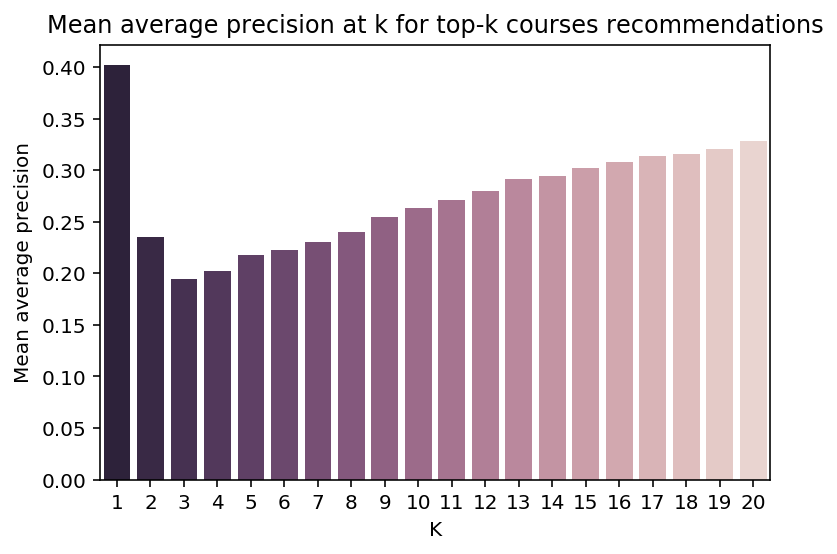

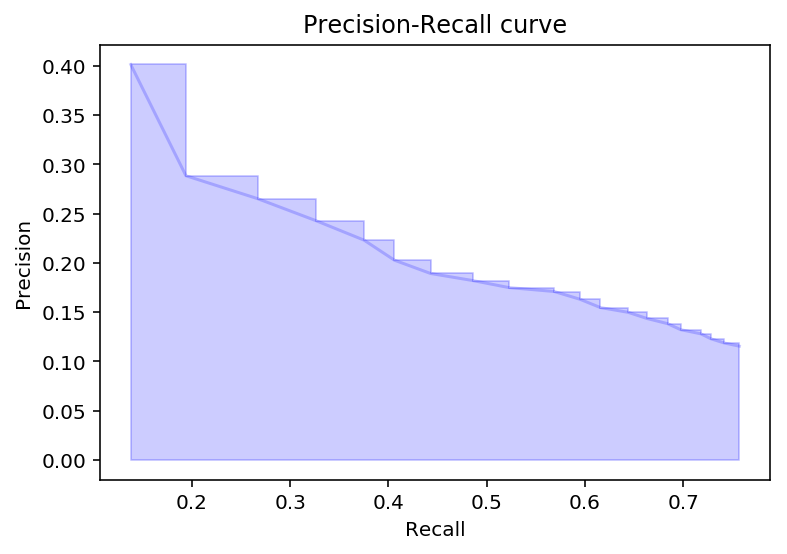

For k = 27 :
For q = 0.998 :
	difference of success rates at 10 - 1: 50.0

	Success Rate at 1: 40.384615
	MAP at 1: 0.40384615384615385
	Precision at 1: 0.40384615384615385
	Recall at 1: 0.13888507326007324
	F1 score at 1: 0.20668868810728636

	Success Rate at 2: 51.201923
	MAP at 2: 0.23918269230769232
	Precision at 2: 0.2932692307692308
	Recall at 2: 0.19692078754578754
	F1 score at 2: 0.23562620913635557

	Success Rate at 3: 62.259615
	MAP at 3: 0.19591346153846154
	Precision at 3: 0.2636217948717948
	Recall at 3: 0.2646119505494506
	F1 score at 3: 0.26411594470453215

	Success Rate at 4: 68.269231
	MAP at 4: 0.20212339743589747
	Precision at 4: 0.23918269230769232
	Recall at 4: 0.3213026556776557
	F1 score at 4: 0.2742267376188472

	Success Rate at 5: 73.798077
	MAP at 5: 0.21254006410256407
	Precision at 5: 0.21682692307692308
	Recall at 5: 0.3646920787545787
	F1 score at 5: 0.271960369507563

	Success Rate at 6: 76.201923
	MAP at 6: 0.22171474358974355
	Precision at 6: 0.19791666

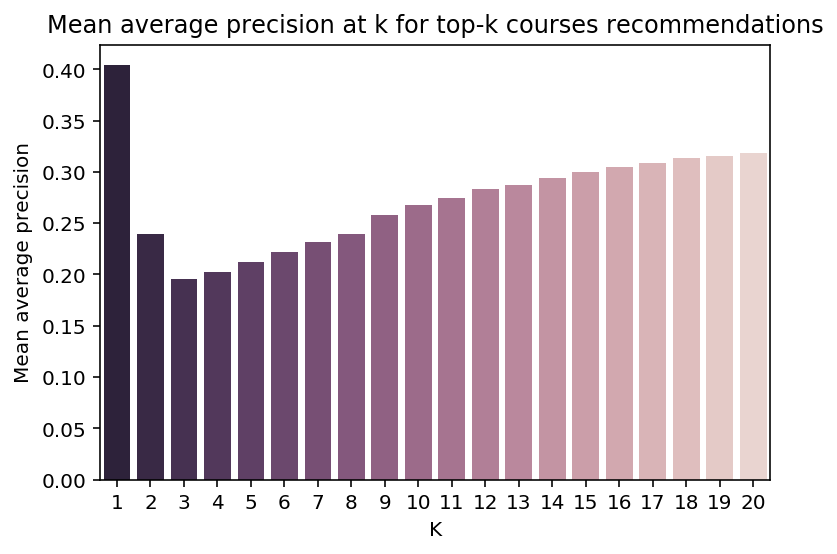

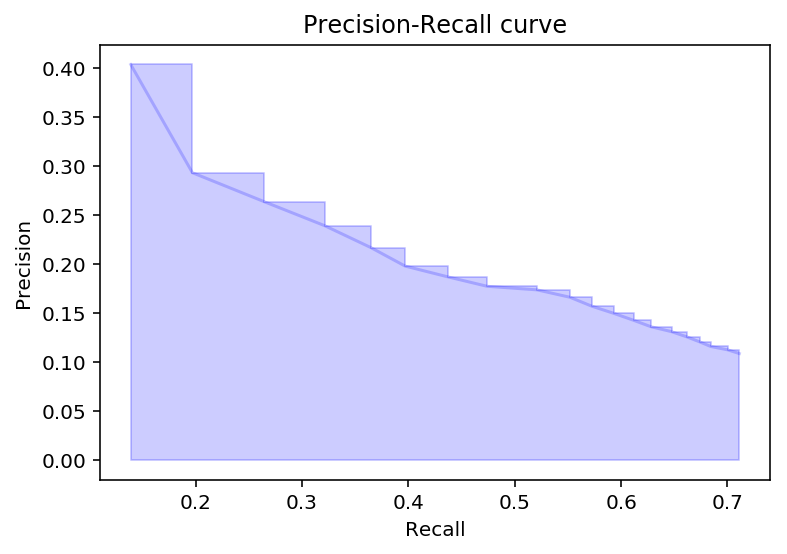

In [14]:
# Baseline + co-enrolment
preds = np.array([ np.array(training_weight_coenrolments(i)) * np.array(nn_weights) for i, nn_weights in enumerate(pred) ])
print_stats_prediction(preds)

# Baseline + grade correlation + co-enrolment
preds = np.array([ np.array(training_weight_coenrolments(i)) * np.array(training_weight_grade_corr(i)) * np.array(nn_weights) for i, nn_weights in enumerate(pred) ])
print_stats_prediction(preds)

# Only baseline
#print_stats_prediction(pred)

# Only co-enrolment
#preds = np.array([ np.array(training_weight_coenrolments(i)) for i, nn_weights in enumerate(pred) ])
#print_stats_prediction(preds)

# Only grade correlations
#preds = np.array([ np.array(training_weight_grade_corr(i)) for i, nn_weights in enumerate(pred) ])
#print_stats_prediction(preds)

# Baseline + grade correlations
#preds = np.array([ np.array(training_weight_grade_corr(i)) * np.array(nn_weights) for i, nn_weights in enumerate(pred) ])
#print_stats_prediction(preds)

# Grade correlations + co-enrolment
#preds = np.array([ np.array(training_weight_coenrolments(i)) * np.array(training_weight_grade_corr(i)) for i, nn_weights in enumerate(pred) ])
#print_stats_prediction(preds)

So the CDAE + matrix of co-enrolment model is about the same as the combination with the matrix of correlation of grades, hence since Occam's razor, we prefer the CDAE + co-enrolment model.

### Splitting into group1, group2 courses

In [15]:
group1_courses = ["Advanced algorithms", "Advanced computer architecture",
                 "Cryptography and security", "Advanced databases",
                 "Distributed algorithms", "Distributed information systems",
                 "Foundations of software", "Information theory and coding",
                 "Pattern classification and machine learning"]
MIN_COURSES_BY_STUDENT_group1 = 2
MIN_COURSES_BY_STUDENT_group2 = 3

group1_courses_matrix = courses_matrix[group1_courses]
group1_courses_matrix = group1_courses_matrix[np.sum(group1_courses_matrix == 1, axis=1) > MIN_COURSES_BY_STUDENT_group1]
group2_courses_matrix = courses_matrix.drop(group1_courses, axis=1)
group2_courses_matrix = group2_courses_matrix[np.sum(group2_courses_matrix == 1, axis=1) > MIN_COURSES_BY_STUDENT_group2]

training_set_group1, testing_set_group1 = split_data(group1_courses_matrix)
training_set_group2, testing_set_group2 = split_data(group2_courses_matrix)

# Numpify the data
train_np_1 = training_set_group1.apply(axis=1, func=lambda x: x.astype(int)).as_matrix()
test_np_1 = testing_set_group1.apply(axis=1, func=lambda x: x.astype(int)).as_matrix()
train_np_2 = training_set_group2.apply(axis=1, func=lambda x: x.astype(int)).as_matrix()
test_np_2 = testing_set_group2.apply(axis=1, func=lambda x: x.astype(int)).as_matrix()

# the indices of each user
users_group1 = np.array(np.arange(group1_courses_matrix.shape[0])[np.newaxis].T, dtype=np.int32)
users_group2 = np.array(np.arange(group2_courses_matrix.shape[0])[np.newaxis].T, dtype=np.int32)

### Prediction for a student

In [16]:
me = [ 
"Distributed information systems",
"Information theory and coding",
"Pattern classification and machine learning",
"Mobile networks",
"Statistical signal and data processing through applications",
"TCP/IP networking",
"Digital education & learning analytics"]
my_courses = pd.DataFrame(data=0, columns=courses_matrix.columns, index=["Romain"])
my_courses[me] = 1
taken_courses = my_courses.loc["Romain"][my_courses.loc["Romain"] == 1].index.tolist()

my_binary_courses = my_courses.as_matrix()
binary_courses_format = np.array([[1]], dtype=np.int32)

In [17]:
prediction_romain = model.predict(x=[my_binary_courses, binary_courses_format])
preds_romain = np.array([ np.array(training_weight_coenrolments(i)) * np.array(training_weight_grade_corr(i)) * np.array(nn_weights) for i, nn_weights in enumerate(prediction_romain) ])
prediction_romain = np.argsort(preds_romain)

predicted_courses = [courses_matrix.columns[i] for i in prediction_romain[0]]
last_year_courses = list(registrations.xs('2015-2016', level='YearName').index)
predicted_courses = [c for c in predicted_courses if c in last_year_courses and c not in taken_courses]

print("I picked the following courses: \n\t-{} \n\nHence we propose the following: \n\t-{}"
     .format("\n\t-".join(taken_courses), "\n\t-".join(predicted_courses[::-1][:10])))

I picked the following courses: 
	-Digital education & learning analytics
	-Distributed information systems
	-Information theory and coding
	-Mobile networks
	-Pattern classification and machine learning
	-Statistical signal and data processing through applications
	-TCP/IP networking 

Hence we propose the following: 
	-Distributed algorithms
	-Cryptography and security
	-Foundations of software
	-Concurrent algorithms
	-Intelligent agents
	-Program parallelization on PC clusters
	-Biometrics
	-Image processing I
	-Advanced computer graphics
	-Information technology and e-business strategy
